<a href="https://colab.research.google.com/github/renanalencar/projeto-cnn-squeezenet/blob/main/cnn_vgg_squeezenet_local_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Redes Neurais 

## Referências: 

1. [Estudo sobre Câncer de Cólon utilizando a mesma base com modelod e CNN](https://www.kaggle.com/aayushrajput/lung-colon-cancer)
2. [Modelo de SqueezeNet para reconhecimento de comida](https://www.kaggle.com/kmader/food-squeezenet) 
3. [SqueezeNet no Keras](https://codelabs.developers.google.com/codelabs/keras-flowers-squeezenet#6)
4. [Entendendo Redes Convolucionais (CNNs) ](https://medium.com/neuronio-br/entendendo-redes-convolucionais-cnns-d10359f21184#:~:text=H%C3%A1%20muitas%20fun%C3%A7%C3%B5es%2C%20como%20sigmoid,quando%20comparada%20a%20outras%20fun%C3%A7%C3%B5es)
5. [Uma introdução as redes neurais convolucionais utilizando o Keras](https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-as-redes-neurais-convolucionais-utilizando-o-keras-41ee8dcc033e)
6. [Tutorial prático do Keras](https://cv-tricks.com/tensorflow-tutorial/keras/)
7. [Métricas de avaliação de modelo](https://gabrielschade.github.io/2019/03/12/ml-classificacao-metricas.html)


## Instalação do pacote keras_applications

In [1]:
!pip install keras_applications

     |████████████████████████████████| 51kB 5.3MB/s 


## Download do dataset direto do Kaggle


*   [Easiest way to download kaggle data in Google Colab](https://www.kaggle.com/general/74235)
*   [Lung and Colon Cancer Histopathological Images](https://www.kaggle.com/andrewmvd/lung-and-colon-cancer-histopathological-images)



In [3]:
# Please follow the steps below to download and use Kaggle data within Google Colab:
# 1. Go to your account, scroll to API section and click 'Expire API Token' to remove previous tokens
# 2. Click on 'Create New API Token' - It will download kaggle.json file on your machine.
# 3. Go to your Google Colab project file and run the following commands:

! pip install -q kaggle
from google.colab import files
# Choose the kaggle.json file that you downloaded 
files.upload()
! mkdir ~/.kaggle
# Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json
# That's all! You can check if everything's okay by running this command.
# ! kaggle datasets list

Saving kaggle.json to kaggle.json


In [4]:
# Download Data
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
# Use unzip command to unzip the data:
# For example, Create a directory named train, ! mkdir train unzip train data there.
! mkdir input
# unzip train data there,
! unzip lung-and-colon-cancer-histopathological-images.zip -d input

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: input/lung

In [5]:
# Criar os diretórios base do projeto:
# 1. Models para guardar os modelos
! mkdir models
# 2. Weights para guardar os pesos do treinamento
! mkdir weights
# 3. Graphs para guardar os gráficos gerados
! mkdir graphs

## Importanto as bibliotecas necessárias

In [57]:
import math

import h5py
import numpy as np

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.engine.topology import get_source_inputs
from keras.models import Model, model_from_json
from keras.layers import Dense,Flatten
from keras.layers import Input, Activation, concatenate
from keras.layers import Flatten, Dropout
from keras.layers import Dense,Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import get_file
from keras.utils import layer_utils
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('error')

# from visual_callbacks import AccLossPlotter

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
%matplotlib inline

## Definição de métricas personalizadas

*   [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
*   [Custom metrics for Keras/TensorFlow](https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05)



In [49]:
def specificity(y_true, y_pred):
  mc = confusion_matrix(y_true, y_pred)
  
  tn_1 = mc[1][1] + mc[1][2] + mc[2][1] + mc[2][2]
  fp_1 = mc[0][1] + mc[0][2]
  spec_1 = tn_1 / (tn_1 + fp_1)

  tn_2 = mc[0][0] + mc[0][2] + mc[2][0] + mc[2][2]
  fp_2 = mc[1][0] + mc[1][2]
  spec_2 = tn_2 / (tn_2 + fp_2)

  tn_3 = mc[0][0] + mc[0][1] + mc[1][0] + mc[1][1]
  fp_3 = mc[2][0] + mc[2][1]
  spec_3 = tn_3 / (tn_3 + fp_3)

  return [spec_1, spec_2, spec_3]

  

In [59]:
def matthews_correlation_coefficient(y_true, y_pred):
  mc = confusion_matrix(y_true, y_pred)

  tn_1 = mc[1][1] + mc[1][2] + mc[2][1] + mc[2][2]
  fp_1 = mc[0][1] + mc[0][2]
  tp_1 = mc[0][0]
  fn_1 = mc[1][0] + mc[2][0]
  num_1 = tp_1 * tn_1 - fp_1 * fn_1
  den_1 = (tp_1 + fp_1) * (tp_1 + fn_1) * (tn_1 + fp_1) * (tn_1 + fn_1)
  mcc_1 = num_1 / math.sqrt(den_1)

  tn_2 = mc[0][0] + mc[0][2] + mc[2][0] + mc[2][2]
  fp_2 = mc[1][0] + mc[1][2]
  tp_2 = mc[1][1]
  fn_2 = mc[0][1] + mc[2][1]
  num_2 = tp_2 * tn_2 - fp_2 * fn_2
  den_2 = (tp_2 + fp_2) * (tp_2 + fn_2) * (tn_2 + fp_2) * (tn_2 + fn_2)
  mcc_2 = num_2 / math.sqrt(den_2)

  tn_3 = mc[0][0] + mc[0][1] + mc[1][0] + mc[1][1]
  fp_3 = mc[2][0] + mc[2][1]
  tp_3 = mc[2][2]
  fn_3 = mc[0][2] + mc[1][2]
  num_3 = tp_3 * tn_3 - fp_3 * fn_3
  den_3 = (tp_3 + fp_3) * (tp_3 + fn_3) * (tn_3 + fp_3) * (tn_3 + fn_3)
  mcc_3 = num_3 / math.sqrt(den_3)

  return [mcc_1, mcc_2, mcc_3]

## Pré-processamento

O conjunto de dados contém 15.000 imagens coloridas em 3 classes, com 5.000 imagens em cada classe. O conjunto de dados é dividido em 12.000 imagens de treinamento e 3.000 imagens de teste (split de 0.2). 

### Variáveis 

In [9]:
base_dir = '/content' # Diretório base
data_dir = base_dir + '/input/lung_colon_image_set/lung_image_sets/' # Diretório do dataset
models_dir = base_dir + '/models/' # Diretório dos modelos salvos
weights_dir = base_dir + '/weights/' # Diretório dos pesos salvos
graphs_dir = base_dir + '/graphs/' # Diretório dos graficos salvos 
width, height, nb_class = 768, 768, 3 # Dimensões da entrada
batch_size = 4 # Tamanho do lote para treinamento
shuffle = True # Sortear as amostras 
seed = 42 # Número de sementes 
nb_epoch = 50 # Número de épocas 
loss='categorical_crossentropy' # Algoritmo de optmização das Redes Convolucionais
optimizer_cnn='adam' # Algoritmo de optmização das Redes Convolucionais
optimizer_sn = 'sgd' # Algoritmo de optmização da SqueezeNet
metrics=['accuracy'] # Métrica utilizada 
target_size = (width, height)
input_shape =  (width, height, nb_class)

### Pré-processamento das imagens 

In [10]:
def PreProcess(data_dir,target_size,batch_size,shuffle,seed):
    
    datagen_cnn = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2)

    train_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='training',
                                          seed = seed)

    validation_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='validation',
                                          seed = seed)

    return train_cnn, validation_cnn 

## CNN

A saída de cada camada Conv2D e MaxPooling2D é um tensor 3D de forma (altura, largura, canais). As dimensões de altura e largura tendem a diminuir à medida que você se aprofunda na rede. O número de canais de saída para cada camada Conv2D é controlado pelo primeiro argumento (por exemplo, 32 ou 64). Normalmente, à medida que a largura e a altura diminuem, você pode (computacionalmente) adicionar mais canais de saída em cada camada Conv2D.

### Modelo de CNN 

As linhas de código abaixo definir a base convolucional utilizando um padrão comum: uma pilha de Conv2D e MaxPooling2D camadas.

Como entrada, um CNN assume tensores de forma (image_height, image_width, color_channels), ignorando o tamanho do lote. O color_channels se refere a (R, G, B). A CNN foi configuradapara processar entradas de forma (768, 768, 3), que é o formato de imagens lung_image_sets. 

In [11]:
def Model_CNN():
  model = models.Sequential()

  # BatchNormalization()(inp) testar o BatchNormalization
  # Block 1
  model.add(layers.BatchNormalization(input_shape=(768, 768, 3)))
  # model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(768, 768, 3))) # Original
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1'))
  model.add(layers.Conv2D(32, (1, 1), activation='relu',name='block1_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block1_pool'))

  # Block 2
  model.add(layers.Conv2D(64, (3, 3), activation='relu', name='block2_conv1'))
  model.add(layers.Conv2D(64, (1, 1), activation='relu',name='block2_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block2_pool'))

  # Block 3
  model.add(layers.Conv2D(128, (3, 3), activation='relu',name='block3_conv1'))
  model.add(layers.Conv2D(128, (1, 1), activation='relu',name='block3_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block3_pool'))

  # Block 4
  model.add(layers.Conv2D(256, (3, 3), activation='relu',name='block4_conv1'))
  model.add(layers.Conv2D(256, (1, 1), activation='relu',name='block4_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block4_pool'))

  # Block 5
  model.add(layers.Conv2D(512, (3, 3), activation='relu',name='block5_conv1'))
  model.add(layers.Conv2D(512, (1, 1), activation='relu',name='block5_conv2'))
  model.add(layers.MaxPooling2D((2, 2),strides=(2, 2), name='block5_pool'))

  # Flatten
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(3, activation='softmax'))
  
  return model

As (768, 768, 64) saídas serão achatadas em vetores de forma (387) antes de passar por duas camadas densas.

Para completar o modelo, o último tensor de saída da base convolucional (de formato (4, 4, 64)) em uma ou mais camadas Densas para realizar a classificação. Camadas densas recebem vetores como entrada (que são 1D), enquanto a saída atual é um tensor 3D. Primeiro, você nivelará (ou desenrolará) a saída 3D em 1D e, em seguida, adicionará uma ou mais camadas Densas na parte superior. O conjunto tem 3 classes de saída, então você usa uma camada Densa final com 3 saídas.

### Função para compilar o modelo da CNN

In [12]:
def Compile_Model_CNN(loss, optimizer_cnn, metrics):
  model_cnn = Model_CNN()
  model_cnn.compile(loss=loss, optimizer=optimizer_cnn, metrics=[metrics])
  model_cnn.summary()
  return model_cnn

### Função de treinamento da CNN

In [13]:
def Train_Model_CNN(model_cnn, train_cnn, nb_epoch, validation_cnn):
    history_cnn = model_cnn.fit(train_cnn, epochs = nb_epoch,  validation_data=validation_cnn)

    # salvar modelo para posterior avaliação      
    model_json = model_cnn.to_json()
    model_name = "Modelo_CNN"
    with open(models_dir + model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    model_cnn.save_weights(weights_dir + model_name +'.h5')
    
    return history_cnn

### Função para execução da CNN

In [14]:
def Execute_Model_CNN():
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)
    model_cnn = Compile_Model_CNN(loss, optimizer_cnn, metrics)
    
    history_cnn = Train_Model_CNN(model_cnn, train_cnn, nb_epoch, validation_cnn)
    
    # Plotar a curva de aprendizagem
    history_dict = history_cnn.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plotar a Perdas vs Épocas
    ax.plot(epochs, loss_values, 'bo', label='Perda de treinamento')
    ax.plot(epochs, val_loss_values, 'b', label='Perda de validação')
    ax.set_title('Perdas de Treinamento & Validação (CNN)', fontsize=16)
    ax.set_xlabel('Épocas', fontsize=16)
    ax.set_ylabel('Perdas', fontsize=16)
    ax.legend()

    ax.figure.savefig(graphs_dir + 'Curva_de_aprendizagem_CNN.png')
  

### Função para avaliação  da CNN

*   F1-Score
*   [Precision](https://classeval.wordpress.com/introduction/basic-evaluation-measures/)
*   Matriz de Confusão
*   [Sensibilidade (Recall Positivo)](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)
*   [Especificidade (Recall Negativo)](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)
*   Coeficiente de Correlação de Matthew

In [61]:
def Evaluate_Model_CNN():

    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)

    # Recuperando o modelo Treinado da CNN
    with open(models_dir + 'Modelo_CNN.json','r') as modelo:
      json = modelo.read()
    model_cnn = model_from_json(json)

    # Recuperando os pesos do treinamento da CNN
    model_cnn.load_weights(weights_dir + 'Modelo_CNN.h5') 

    # predicted_cnn = model_cnn.predict(validation_cnn)

    # Y_pred = model_cnn.predict_generator(validation_cnn, steps=4500 // batchsize+1)
    Y_pred = model_cnn.predict(validation_cnn)
    y_pred = np.argmax(Y_pred, axis=1)

    print(" ---- Overall F1 Score ----")
    print(f1_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')
    
    print(" ---- Overall Precision ----")
    print(precision_score(validation_cnn.classes, y_pred, average = 'micro', zero_division=1))
    print(precision_score(validation_cnn.classes, y_pred, average = 'macro', zero_division=1))
    print(precision_score(validation_cnn.classes, y_pred, average = 'weighted', zero_division=1),'\n')

    print(" ---- Matriz de Confusão ----")
    print(confusion_matrix(validation_cnn.classes, y_pred),'\n')

    print(" ---- Overall Recall (Sensibilidade) ----")
    print(recall_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')

    print(" ---- Especificidade ----")
    #print(specificity(validation_cnn.classes, y_pred),'\n')
    spec = specificity(validation_cnn.classes, y_pred)    
    print('aca: ', spec[0])
    print('n: ', spec[1])
    print('scc: ', spec[2],'\n')

    print(" ---- Coeficiente de Correlação de Matthew ----")
    #print(matthews_correlation_coefficient(validation_cnn.classes, y_pred),'\n')
    mcc = matthews_correlation_coefficient(validation_cnn.classes, y_pred)
    print('aca: ', mcc[0])
    print('n: ', mcc[1])
    print('scc: ', mcc[2],'\n')

    print(" ---- Relatório da Classificação ---")
    print(classification_report(validation_cnn.classes, y_pred, target_names=['aca', 'n', 'scc']), '\n')

### Chamada para execução da CNN

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 768, 768, 3)       12        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 768, 32)      896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 768, 32)      1056      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 384, 32)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 382, 382, 64)      18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 382, 382, 64)      4160      
_____________________________________

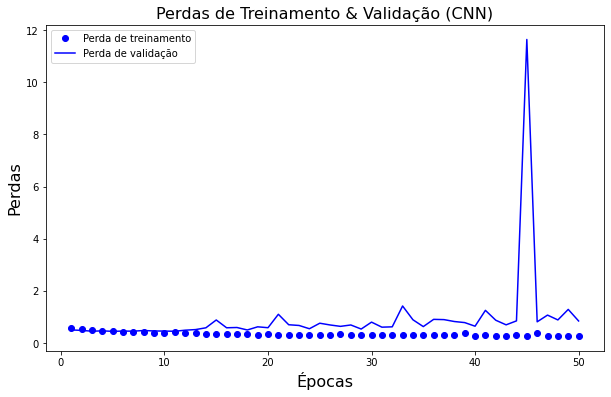

In [16]:
Execute_Model_CNN()

### Chamada para avaliação da CNN

In [62]:
Evaluate_Model_CNN()

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
 ---- Overall F1 Score ----
0.33666666666666667
0.33304857713642244
0.3330485771364225 

 ---- Overall Precision ----
0.33666666666666667
0.33716873610304116
0.33716873610304127 

 ---- Matriz de Confusão ----
[[251 331 418]
 [251 339 410]
 [232 348 420]] 

 ---- Overall Recall (Sensibilidade) ----
0.33666666666666667
0.33666666666666667
0.33666666666666667 

 ---- Especificidade ----
aca:  0.6694616063548102
n:  0.6664984863773966
scc:  0.6689497716894978 

 ---- Coeficiente de Correlação de Matthew ----
aca:  0.010417430707738535
n:  -0.0004978050386329531
scc:  0.0057384143600611075 

 ---- Relatório da Classificação ---
              precision    recall  f1-score   support

         aca       0.34      0.25      0.29      1000
           n       0.33      0.34      0.34      1000
         scc       0.34      0.42      0.37      1000

    accuracy                           0.34      3000
   macro av

# VGG

### Modelo VGG

In [63]:
def Model_VGG():
  model = VGG16(include_top=False, input_shape=(768, 768, 3))

  for layer in model.layers:
   layer.trainable = False
  
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(1024, activation='relu')(flat1)
  class2 = Dense(512, activation='relu')(class1)
  class3 = Dense(256, activation='relu')(class2)
  class4 = Dense(128, activation='relu')(class3)
  output = Dense(3, activation='softmax')(class4)

  model = Model(inputs=model.inputs, outputs=output)

  return model

### Função para compilar o modelo da VGG

In [64]:
def Compile_Model_VGG(loss, optimizer_cnn, metrics):
  
  model_vgg = Model_VGG()
  model_vgg.compile(loss=loss, optimizer=optimizer_cnn, metrics=[metrics])
  model_vgg.summary()

  return model_vgg

### Função de treinamento da VGG

In [65]:
def Train_Model_VGG(model_vgg, train_cnn, nb_epoch, validation_cnn):
     
     history_vgg = model_vgg.fit(train_cnn, epochs = nb_epoch,  validation_data=validation_cnn)

     # salvar modelo para posterior avaliação      
     model_json = model_vgg.to_json()
     model_name = "Modelo_VGG"
     with open(models_dir + model_name + ".json", "w") as json_file:
      json_file.write(model_json)
     model_vgg.save_weights(weights_dir + model_name + '.h5')

     return history_vgg

### Função para execução da VGG

In [66]:
def Execute_Model_VGG():
  
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)
    model_vgg = Compile_Model_VGG(loss, optimizer_cnn, metrics)
    history_vgg = Train_Model_VGG(model_vgg, train_cnn, nb_epoch, validation_cnn)

    # Plotar a curva de aprendizagem
    history_dict = history_vgg.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plotar a Perdas vs Épocas
    ax.plot(epochs, loss_values, 'bo', label='Perda de treinamento')
    ax.plot(epochs, val_loss_values, 'b', label='Perda de validação')
    ax.set_title('Perdas de Treinamento & Validação (VGG)', fontsize=16)
    ax.set_xlabel('Épocas', fontsize=16)
    ax.set_ylabel('Perdas', fontsize=16)
    ax.legend()

    ax.figure.savefig(graphs_dir + 'Curva_de_aprendizagem_VGG.png')
  

### Função para avaliação  da VGG

In [67]:
def Evaluate_Model_VGG():

    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)

    # Recuperando o modelo Treinado da CNN
    with open(models_dir + 'Modelo_VGG.json','r') as modelo:
      json = modelo.read()
    model_vgg = model_from_json(json)

    # Recuperando os pesos do treinamento da CNN
    model_vgg.load_weights(weights_dir + 'Modelo_VGG.h5') 

    Y_pred = model_vgg.predict(validation_cnn)
    y_pred = np.argmax(Y_pred, axis=1)

    print(" ---- F1 Score ----")
    print(f1_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')

    print(" ---- Precision ----")
    print(precision_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(precision_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(precision_score(validation_cnn.classes, y_pred, average = 'weighted', zero_division=1),'\n')

    print(" ---- Matriz de Confusão ----")
    print(confusion_matrix(validation_cnn.classes, y_pred),'\n')

    print(" ---- Recall (Sensibilidade) ----")
    print(recall_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')
    
    print(" ---- Especificidade ----")
    #print(specificity(validation_cnn.classes, y_pred),'\n')
    spec = specificity(validation_cnn.classes, y_pred)    
    print('aca: ', spec[0])
    print('n: ', spec[1])
    print('scc: ', spec[2],'\n')

    print(" ---- Coeficiente de Correlação de Matthew ----")
    #print(matthews_correlation_coefficient(validation_cnn.classes, y_pred),'\n')
    mcc = matthews_correlation_coefficient(validation_cnn.classes, y_pred)
    print('aca: ', mcc[0])
    print('n: ', mcc[1])
    print('scc: ', mcc[2],'\n')

    print(" ---- Relatório da Classificação ---")
    print(classification_report(validation_cnn.classes, y_pred, target_names=['aca', 'n', 'scc']), '\n')

### Chamada para execução da VGG

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768, 768, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 768, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 768, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 384, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 384, 384, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 384, 38

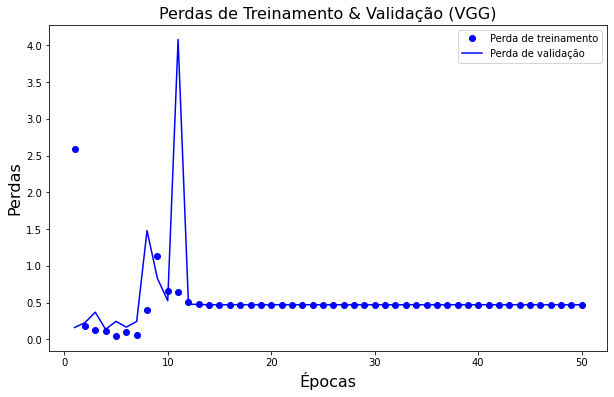

In [73]:
Execute_Model_VGG()

### Chamada para avaliação da VGG

In [74]:
Evaluate_Model_VGG()

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
 ---- F1 Score ----
0.33166666666666667
0.25824273095179456
0.25824273095179456 

 ---- Precision ----
0.33166666666666667


UndefinedMetricWarning: ignored

# SqueezeNet

### Modelo SqueezeNet

In [68]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


def Model_SqzNet(include_top=True, weights='imagenet', 
               input_tensor=None, input_shape=None,
               pooling=None,
               use_bn_on_input = False,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input

    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                print('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

### Função para compilar o modelo da SqueezeNet

In [69]:
def Compile_Model_SqzNet(input_shape, nb_class, loss, optimizer_sn, metrics):
 
  model_sn = Model_SqzNet(input_shape=input_shape,  weights=None, classes = nb_class)
  sgd = SGD(lr=0.001, decay=0.0002, momentum=0.9, nesterov=True)
  model_sn.compile(loss=loss, optimizer=optimizer_sn, metrics=[metrics])
  model_sn.summary()

  return model_sn

### Função para treinamento  da SqueezeNet

In [70]:
def Train_Model_SqzNet(model_sn, train_cnn, nb_epoch, validation_cnn):
    
    history_sn = model_sn.fit(train_cnn, epochs = nb_epoch,  validation_data=validation_cnn)

    # salvar modelo para posterior avaliação      
    model_json = model_sn.to_json()
    model_name = "Modelo_SqzNet"
    with open(models_dir + model_name + ".json", "w") as json_file:
      json_file.write(model_json)
    model_sn.save_weights(weights_dir + model_name + '.h5')

    return history_sn

### Função para execuação  da SqueezeNet

In [71]:
def Execute_Model_SqzNet():
    
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)
    model_sn = Compile_Model_SqzNet(input_shape, nb_class, loss, optimizer_sn, metrics)
    history_sn = Train_Model_SqzNet(model_sn, train_cnn, nb_epoch, validation_cnn)

    # Plotar a curva de aprendizagem
    history_dict = history_sn.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plotar a Perdas vs Épocas
    ax.plot(epochs, loss_values, 'bo', label='Perda de treinamento')
    ax.plot(epochs, val_loss_values, 'b', label='Perda de validação')
    ax.set_title('Perdas de Treinamento & Validação (SqueezeNet)', fontsize=16)
    ax.set_xlabel('Épocas', fontsize=16)
    ax.set_ylabel('Perdas', fontsize=16)
    ax.legend()

    ax.figure.savefig(graphs_dir + 'Curva_de_aprendizagem_SqzNet.png')

### Função para avaliação  da SqueezeNet

In [72]:
def Evaluate_Model_SqzNet():
    
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)

    # Recuperando o modelo Treinado da CNN
    with open(models_dir + 'Modelo_SqzNet.json','r') as modelo:
      json = modelo.read()
    model_vgg = model_from_json(json)

    # Recuperando os pesos do treinamento da CNN
    model_vgg.load_weights(weights_dir + 'Modelo_SqzNet.h5') 

    Y_pred = model_vgg.predict(validation_cnn)
    y_pred = np.argmax(Y_pred, axis=1)

    print(" ---- F1 Score ----")
    print(f1_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(f1_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')
    
    print(" ---- Precision ----")
    print(precision_score(validation_cnn.classes, y_pred, average = 'micro', zero_division=1))
    print(precision_score(validation_cnn.classes, y_pred, average = 'macro', zero_division=1))
    print(precision_score(validation_cnn.classes, y_pred, average = 'weighted', zero_division=1),'\n')

    print(" ---- Matriz de Confusão ----")
    print(confusion_matrix(validation_cnn.classes, y_pred),'\n')

    print(" ---- Recall (Sensibilidade) ----")
    print(recall_score(validation_cnn.classes, y_pred, average = 'micro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'macro'))
    print(recall_score(validation_cnn.classes, y_pred, average = 'weighted'),'\n')

    print(" ---- Especificidade ----")
    #print(specificity(validation_cnn.classes, y_pred),'\n')
    spec = specificity(validation_cnn.classes, y_pred)    
    print('aca: ', spec[0])
    print('n: ', spec[1])
    print('scc: ', spec[2],'\n')

    print(" ---- Coeficiente de Correlação de Matthew ----")
    #print(matthews_correlation_coefficient(validation_cnn.classes, y_pred),'\n')
    mcc = matthews_correlation_coefficient(validation_cnn.classes, y_pred)
    print('aca: ', mcc[0])
    print('n: ', mcc[1])
    print('scc: ', mcc[2],'\n')

    print(" ---- Relatório da Classificação ---")
    print(classification_report(validation_cnn.classes, y_pred, target_names=['aca', 'n', 'scc']), '\n')

### Chamada para execução da SqueezeNet

In [ ]:
Execute_Model_SqzNet()

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 383, 383, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 383, 383, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 191, 191, 64) 0           relu_conv1[0][0]                 
____

### Chamada para avaliação da SqueezeNet

In [ ]:
Evaluate_Model_SqzNet()